# Notebook to anaylze the activations of the chess dataset
- It will evaluate the answers of the LLM
- Train probes on the activations based on the LLM output
- Main goals of investigation are:
    - Is it possible to predict the LLMs final answer from the last query token prediction. 
    - Is it possible to accurately distinguish reasoning (correct answers on counterfactual task) from reciting (incorrect but existing (yes) answers)

In [2]:
from typing import Literal
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from datasets import load_dataset, Dataset, load_from_disk
import matplotlib.pyplot as plt

/Users/jorisholshuijsen/Library/Caches/pypoetry/virtualenvs/interaction-experiment--8j9mRgr-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the chess dataset from huggingface
chess_dataset_complete = load_dataset("JorisHolshuijsen/chess")

# Display basic information about the dataset
print(f"Dataset structure: {chess_dataset_complete}")
print(f"Available splits: {chess_dataset_complete.keys()}")




Dataset structure: DatasetDict({
    train: Dataset({
        features: ['prompt', 'llm_response', 'mlp_activations', 'attention_activations', 'residual_activations', 'mode', 'real_world_answer', 'counter_factual_answer', 'opening'],
        num_rows: 808
    })
})
Available splits: dict_keys(['train'])


## Evaluate the LLM response to find it's answer to the chess query

First we see if the LLM answers the control questions truthfully to ensure it understands the countefactual chess variant.
From this analysis it's interesting to see that it correctly answers the control versions for the white bishop and knights but fails to generate any good answer for the black pieces (in the counterfactual variant) - it seem's like it gets one correct but if you analyze the prompt it's not part of the positions in clearly declares as the correct positions.

In the real world setting it incorrectly identiefies the black knights as being positioned at b1 g1 (white knight positions), this wrong belief could potentially lead to the mixups in the counterfactual setting. It is strange it's having trouble with this identification

In [3]:
"""Code to check if the LLM is aware of the counterfactual setting"""
# Evaluate control performance on the first 8 entries as these are the control answers

# Get the first 8 entries from the dataset
control_samples_real_world = chess_dataset_complete['train'].select(range(4))
control_samples_cf = chess_dataset_complete['train'].select(range(4,8))

def evaluate_chess_control(dataset, mode):
    """
    Evaluate control questions for chess positions with the new output format.
    """
    # Define ground truth positions
    pos_bishop = ["c1", "f1", "c8", "f8"] if mode == "real_world" else ["b1", "g1", "b8", "g8"]
    pos_knight = ["b1", "g1", "b8", "g8"] if mode == "real_world" else ["c1", "f1", "c8", "f8"]
    
    gt_dict = {
        "white bishop": pos_bishop[:2],
        "black bishop": pos_bishop[2:],
        "white knight": pos_knight[:2],
        "black knight": pos_knight[2:]
    }
    
    success = 0
    count = 0
    
    for i in range(len(dataset)):
        response = dataset[i]['llm_response'].lower()
        
        # Extract the piece type being asked about
        piece_type = None
        for key in gt_dict.keys():
            if f"the two {key}s" in response or f"the two {key}" in response:
                piece_type = key
                break
        #print(piece_type, gt_dict[piece_type])

        if not piece_type:
            print(f"Warning: Could not determine piece type in: {response[:100]}...")
            continue
        
        # Assuming the answer comes after "Answer:" or after the question
        answer_part = None
        if "answer:" in response:
            answer_part = response.split("assistant:", 1)[1].strip()
        elif "?" in response:
            answer_part = response.split("?", 1)[1].strip()
        else:
            print(f"Warning: Could not find answer section in: {response[:100]}...")
            continue
        
        # Check if correct positions are mentioned in the answer
        for pos in gt_dict[piece_type]:
            count += 1
            if pos in answer_part:
                success += 1
    
    accuracy = (success / count * 100) if count > 0 else 0

    return accuracy

print("Real world control accuracy: ", evaluate_chess_control(control_samples_real_world, 'real_world'))
print('Counterfactual world accuracy: ', evaluate_chess_control(control_samples_cf, 'counter_factual'))


Real world control accuracy:  75.0
Counterfactual world accuracy:  62.5


### Extract the answers yes/no from the LLM

In [12]:
"""Code to extract the answers from the LLM"""

def evaluate_llm_response(dataset: Dataset):    
    yes_count = 0
    no_count = 0
    invalid_count = 0
    invalid_answers = []
    
    results = []
    
    for i in range(len(dataset)):
        response = dataset[i]['llm_response'].lower()
        # Extract the answer part
        answer_part = None
        if "### answer:" in response:
            answer_part = response.split("### answer:", 1)[1].strip()
        else:
            print("Warning: Could not identify answer part in LLM response")
            invalid_count += 1
            continue
        
        # Look for boxed yes/no
        has_yes = r"\boxed{yes}" in answer_part
        has_no = r"\boxed{no}" in answer_part
        
        # Check if both yes and no are present
        answer_part = answer_part.replace(".", " ")
        answer_part = answer_part.strip()
        last_line = answer_part.split("\n")[-1]
        success = False
        if has_yes and has_no:
            print(f"Warning: Both \\boxed{{yes}} and \\boxed{{no}} found in answer: {answer_part[:100]}...")
            invalid_answers.append(answer_part)
            invalid_count += 1
            results.append('invalid')
            continue

            
        if has_yes:
            results.append('yes')
            success = True
        elif answer_part.endswith('is legal'):
            results.append("yes")
            success = True
        elif 'are legal' in last_line or 'is legal' in last_line:
            success = True
            results.append("yes")

        if has_no:
            results.append("no")
            success = True
        elif answer_part.endswith('illegal') or answer_part.endswith('not legal'):
            results.append("no")
            success = True
        elif 'not legal' in last_line or 'illegal' in last_line or 'not valid' in last_line or 'not a valid' in last_line:
            results.append("no")
            success = True

        if not success:
            print("Warning: Could not identify an answer")
            invalid_answers.append(answer_part)
            results.append("invalid")

    yes_count = results.count("yes")
    no_count = results.count("no")
    invalid_count = results.count("invalid")
    evaluated_answer_count = len(results)
    if evaluated_answer_count != len(dataset):
        print("Warning: some answers seem to be ambigous as total evaluated answer length" 
              f"{evaluated_answer_count} does not match the dataset length {len(dataset)}"
              )
    
    print(f"Yes answers: {yes_count}")
    print(f"No answers: {no_count}")
    print(f"Invalid answers: {invalid_count}")
    
    return results, invalid_answers

## Exclude the first 8 selections as they include the control quesetions
chess_dataset =  chess_dataset_complete['train'].select(range(8, len(chess_dataset_complete['train'])))
results, invalid_answers = evaluate_llm_response(dataset=chess_dataset)

NameError: name 'chess_dataset_complete' is not defined

In [5]:
# Add the results to the chess dataset
# Create a new column 'result' in the chess dataset with the evaluation results
chess_dataset = chess_dataset.add_column('result', results)

### Fixing errors with datbase parsing

In [6]:
# Create new mode column using Dataset.map()

def set_mode(example):
    if 'variant' in example['prompt']:
        example['mode'] = 'counter_factual'
    else:
        example['mode'] = 'real_world'
    return example

def set_answer(example, idx):
    """
    Set the expected answer based on the example's mode.
    """
    if idx < 200:
        example['counter_factual_answer'] = True
        example['real_world_answer'] = False
    elif idx < 400:
        example['counter_factual_answer'] = False
        example['real_world_answer'] = True
    elif idx < 600:
        example['counter_factual_answer'] = True
        example['real_world_answer'] = False
    else:
        example['counter_factual_answer'] = False
        example['real_world_answer'] = True
    return example

def exclude_invalid(example):
    if example['result'] == 'invalid':
        return None
    return example

def validate_answer(example):
    answer_key = example['real_world_answer'] if example['mode'] == "real_world" else example['counter_factual_answer']
    example['correct'] = (example['result'] == "yes" and answer_key) or (example['result'] == "no" and not answer_key)
    return example

# Exclude all invalid types from the dataset
chess_dataset = chess_dataset.map(exclude_invalid)
# Apply the mapping to create a new dataset with the mode column properly set
chess_dataset = chess_dataset.map(set_mode)
chess_dataset = chess_dataset.map(set_answer, with_indices=True)
chess_dataset = chess_dataset.map(validate_answer)

# Save the dataset locally
# Save the dataset to disk in Hugging Face's dataset format
chess_dataset.save_to_disk("chess_dataset")


Saving the dataset (3/3 shards): 100%|██████████| 786/786 [00:02<00:00, 364.63 examples/s]


In [7]:
real_world_counter = {'yes': 0, 'no': 0 ,'invalid': 0}
cf_world_counter = {'yes': 0, 'no': 0 ,'invalid': 0}
rw_correct = 0
cf_correct = 0

for example in chess_dataset:
    if example['mode'] == "real_world":
        counter = real_world_counter
        #print(example['mode'], example['result'], example['real_world_answer'])
        if example['result'] == "yes" and example['real_world_answer']:
            rw_correct += 1
        elif example['result'] == 'no' and not example['real_world_answer']:
            rw_correct += 1

    elif example['mode'] == "counter_factual":
        counter = cf_world_counter
        #print(example['mode'], example['result'], example['counter_factual_answer'])
        if example['result'] == "yes" and example['counter_factual_answer']:
            cf_correct += 1
        elif example['result'] == 'no' and not example['counter_factual_answer']:
            cf_correct += 1
    else:
        raise Exception
    
    counter[example['result']] += 1


In [8]:
print("Real world stats")
print("Number of Yes instances: ", real_world_counter['yes'])
print("Number of No instances: ", real_world_counter['no'])
print("Number of Invalid instances: ", real_world_counter['invalid'])
total_rw_instances = sum(real_world_counter.values())
print("Total real world instances: ", total_rw_instances)
print("Number of correct answers: ", rw_correct)
print("LLM accuracy: ", rw_correct/(total_rw_instances - real_world_counter['invalid']))

print("\nCounter-factual world stats")
print("Number of Yes instances: ", cf_world_counter['yes'])
print("Number of No instances: ", cf_world_counter['no'])
print("Number of Invalid instances: ", cf_world_counter['invalid'])
total_cf_instances = sum(cf_world_counter.values())
print("Total counter-factual instances: ", total_cf_instances)
print("Number of correct answers: ", cf_correct)
print("LLM accuracy: ", cf_correct/(total_cf_instances - cf_world_counter['invalid']))


Real world stats
Number of Yes instances:  155
Number of No instances:  243
Number of Invalid instances:  0
Total real world instances:  398
Number of correct answers:  227
LLM accuracy:  0.5703517587939698

Counter-factual world stats
Number of Yes instances:  165
Number of No instances:  223
Number of Invalid instances:  0
Total counter-factual instances:  388
Number of correct answers:  199
LLM accuracy:  0.5128865979381443


In [154]:


# Extract features and labels from the dataset
def prepare_data(dataset: Dataset, num_layers: int, labelling_function, mode: Literal[None, 'real_world', 'counter_factual'] = None):
    # Return the activations in the appropriate, flattened, format
    data = []
    labels = []
    
    for example in dataset:
        if example['mode'] == mode:
            labels.append(labelling_function(example=example))
        elif mode is None:
            labels.append(labelling_function(example=example))
        
        layer_activations = {i: [] for i in range(num_layers)}
        if example['mode'] == mode:   # Get the last token's activation
            for layer_idx in range(num_layers):
                activations = example['residual_activations']
                layer_activations[layer_idx] = np.array(activations[layer_idx]).flatten()
            data.append(layer_activations)
        elif mode is None:
            for layer_idx in range(num_layers):
                activations = example['residual_activations']
                layer_activations[layer_idx] = np.array(activations[layer_idx]).flatten()
            data.append(layer_activations)

    
    return data, np.array(labels)


def extract_label(example):
    if example['result'] == "yes":
        label = 1
    elif example['result'] == "no":
        label = 0
    return label



In [195]:
def train_layer_classifiers(data, labels, num_layers=32, random_state=42, verbose=False, regularization=False):
    """
    Train logistic regression classifiers for each layer and return predictions and test labels.
    
    Args:
        data: List of dictionaries containing layer activations
        labels: Array of labels
        num_layers: Number of layers in the model
        random_state: Random seed for reproducibility
        verbose: Whether to print verbose output
        shuffle_data: If True, shuffle the labels to create a random baseline
        
    Returns:
        y_preds: List of predictions for each layer
        y_tests: List of test labels for each layer
    """
    y_preds = []
    y_tests = []
    probes = []
    
    y = labels.copy()
    # if shuffle_data:
    #     np.random.seed(random_state)
    #     np.random.shuffle(y)
    #     if verbose:
    #         print("Labels have been shuffled for random baseline")
    
    for i in range(num_layers):
        X = np.array([d[i] for d in data])
        if regularization:
            # Exclude feature 2354 and 4055
            # Create a mask to exclude specific features
            mask = np.ones(X.shape[1], dtype=bool)
            mask[2352] = False
            mask[4055] = False
            mask[2298] = False
            mask[2209] = False
            mask[517] = False
            mask[788] = False
            mask[1162] = False

            X = X[:, mask]

        if verbose:
            print(f"Shape of features: {X.shape}, Shape of labels: {y.shape}")
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state
        )
        if verbose:
            print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")

        y_tests.append(y_test)
        if verbose:
            print(f"Training classifier on layer {i}")
        if regularization:
            clf = LogisticRegression(max_iter=1000, random_state=random_state, C=1, penalty='l2', solver='liblinear')
        else:
            clf = LogisticRegression(max_iter=1000, random_state=random_state)
        clf.fit(X_train, y_train)
        probes.append(clf)
        if verbose:
            print(f"Largest weights for layer {i}")
            # Get the weights and their indices
            weights = clf.coef_[0]
            # Get indices of the largest 10 weights by absolute value
            largest_indices = np.argsort(np.abs(weights))[-10:][::-1]
            # Print the largest 10 weights and their indices
            for idx in largest_indices:
                print(f"Index {idx}: {weights[idx]}")

        y_pred = clf.predict(X_test)

        y_preds.append(y_pred)
        
        if verbose:
            print(f"Accuracy for layer {i}: ", accuracy_score(y_test, y_pred))
    
    return y_preds, y_tests, probes



Shape of features: (786, 4096), Shape of labels: (786,)
Training classifier on layer 0
Accuracy for layer 0:  0.5822784810126582
Shape of features: (786, 4096), Shape of labels: (786,)
Training classifier on layer 1
Accuracy for layer 1:  0.5822784810126582
Shape of features: (786, 4096), Shape of labels: (786,)
Training classifier on layer 2
Accuracy for layer 2:  0.5822784810126582
Shape of features: (786, 4096), Shape of labels: (786,)
Training classifier on layer 3
Accuracy for layer 3:  0.5822784810126582
Shape of features: (786, 4096), Shape of labels: (786,)
Training classifier on layer 4
Accuracy for layer 4:  0.5822784810126582
Shape of features: (786, 4096), Shape of labels: (786,)
Training classifier on layer 5
Accuracy for layer 5:  0.5822784810126582
Shape of features: (786, 4096), Shape of labels: (786,)
Training classifier on layer 6
Accuracy for layer 6:  0.5822784810126582
Shape of features: (786, 4096), Shape of labels: (786,)
Training classifier on layer 7
Accuracy f

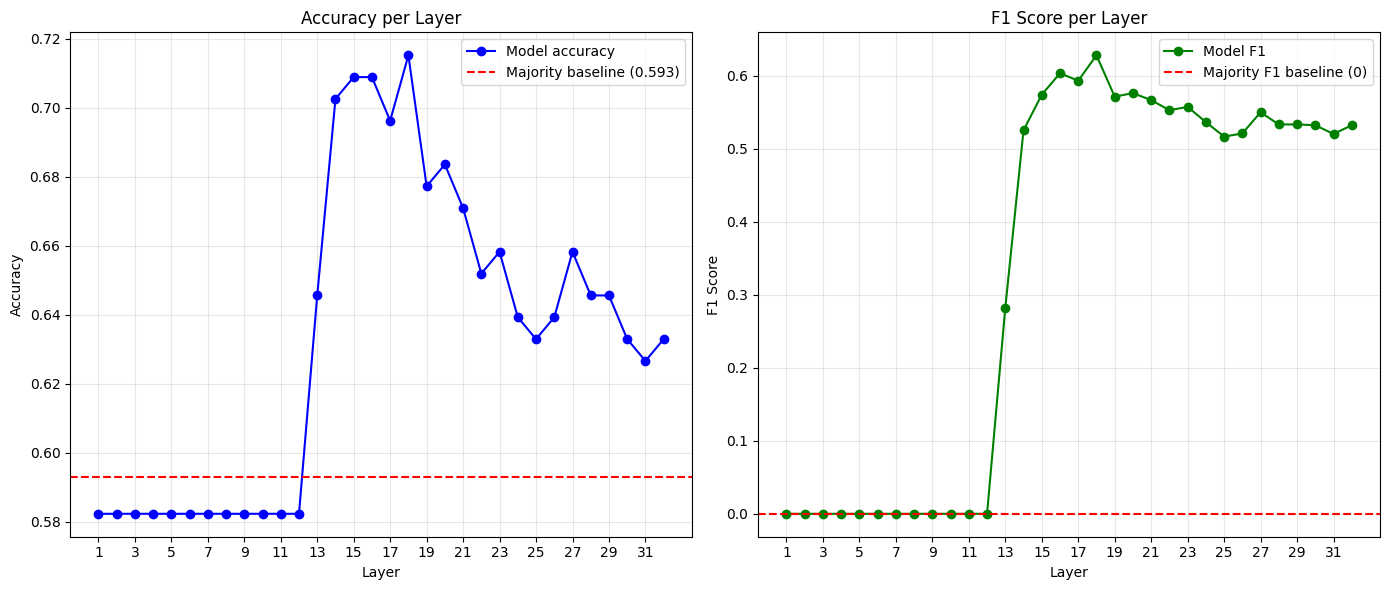

In [27]:
def plot_layer_metrics(y_preds, y_tests, labels, num_layers):
    """
    Plot accuracy and F1 scores for each layer.
    
    Args:
        y_preds: List of predictions for each layer
        y_tests: List of test labels for each layer
        labels: Array of all labels (used for majority baseline)
        num_layers: Number of layers in the model
        
    Returns:
        accuracies: List of accuracy scores for each layer
        f1_scores: List of F1 scores for each layer
    """
    # Calculate accuracy and F1 score for each layer
    accuracies = []
    f1_scores = []

    # Calculate majority class baseline
    majority_class = np.bincount(labels).argmax()  # Find the most common class
    majority_percentage = np.bincount(labels)[majority_class] / len(labels)
    majority_baseline = majority_percentage

    for i in range(num_layers):
        y_test = y_tests[i]
        y_pred = y_preds[i]
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='binary')
        
        accuracies.append(acc)
        f1_scores.append(f1)

    # Create a figure with two subplots
    plt.figure(figsize=(14, 6))

    # Plot accuracy per layer
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_layers + 1), accuracies, marker='o', linestyle='-', color='blue', label='Model accuracy')
    plt.axhline(y=majority_baseline, color='r', linestyle='--', label=f'Majority baseline ({majority_baseline:.3f})')
    plt.xlabel('Layer')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Layer')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, num_layers + 1, 2))  # Show every other layer number for clarity
    plt.legend()

    # Plot F1 score per layer
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_layers + 1), f1_scores, marker='o', linestyle='-', color='green', label='Model F1')
    plt.axhline(y=0, color='r', linestyle='--', label='Majority F1 baseline (0)')  # F1 score of majority class baseline is 0
    plt.xlabel('Layer')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Layer')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, num_layers + 1, 2))  # Show every other layer number for clarity
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return accuracies, f1_scores


#### Setup

In [138]:
chess_dataset = load_from_disk("chess_dataset")

num_layers =  32
random_state = 42
y_preds = []
y_tests = []

In [77]:
# real_world_prompts = []
# cf_prompts = []
# for example in chess_dataset:
#     if example['mode'] == 'real_world' and len(real_world_prompts) < 10:
#         real_world_prompts.append(example['prompt'])
#     if example['mode'] == 'counter_factual' and len(cf_prompts) < 10:
#         cf_prompts.append(example['prompt'])
#     if len(cf_prompts) == 10 and len(real_world_prompts) == 10:
#         break

In [145]:
data, labels = prepare_data(chess_dataset, labelling_function=extract_label, num_layers=num_layers)

### Q1: can we reliably predict the answer the LLM will give from the last token of residual stream activations before it starts generating the code.
- Train a probe to predict the correct answer based on the activatios

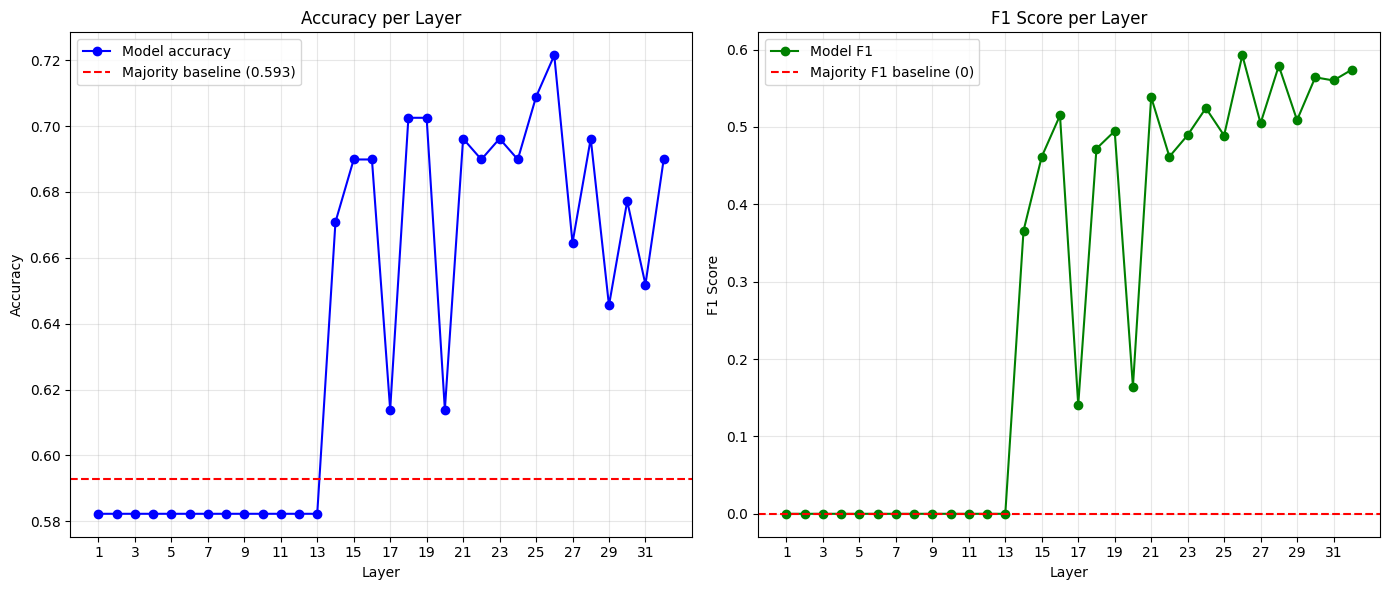

In [146]:
y_preds, y_tests, _ = train_layer_classifiers(data, labels)
# Call the function with our data
accuracies, f1_scores = plot_layer_metrics(y_preds, y_tests, labels, num_layers)

### Q2: Is it possible to distinguish reasoning (counterfactual correct) from reciting?

In [147]:
# Subset: all counterfactual answeres
# Label for reasoning: counterfactual correct label = True.
# Label for reciting: 

def label_correct(example):
    """Labels all correct instances as one"""
    if example['correct']: 
        label = 1
    else:
        label = 0
    return label
    

data, labels = prepare_data(chess_dataset, 32, label_correct, mode='counter_factual')

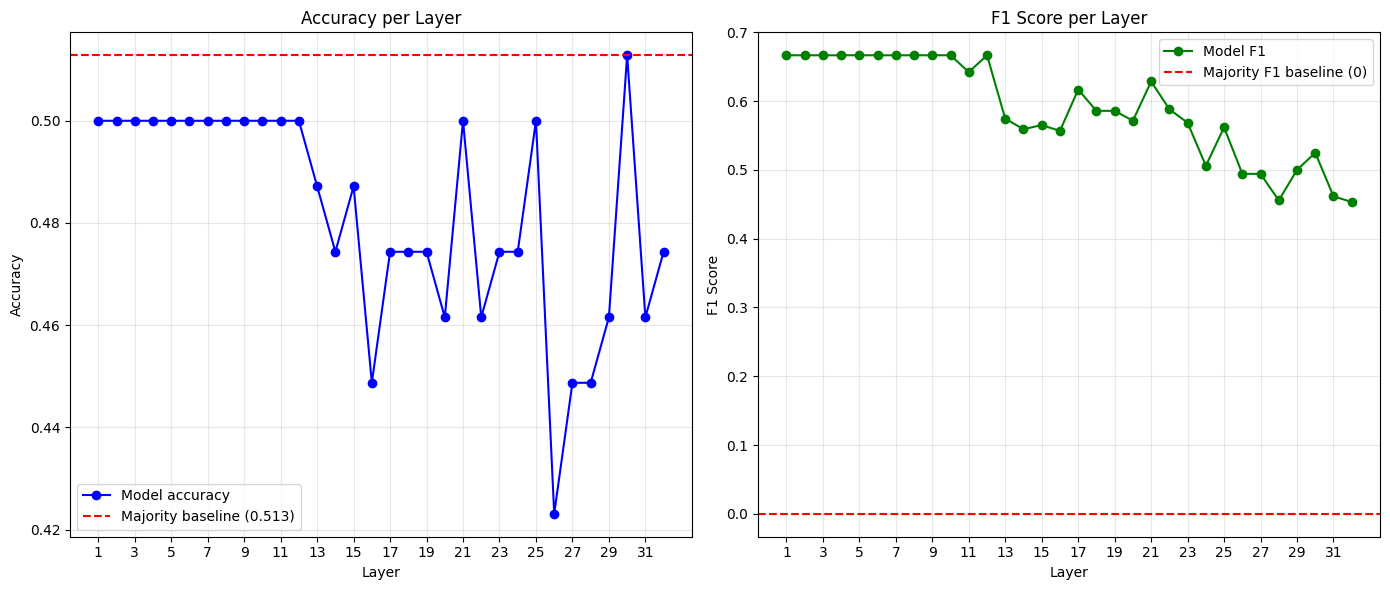

In [148]:
y_preds, y_tests, _ = train_layer_classifiers(data, labels)
accuracies, f1_scores = plot_layer_metrics(y_preds, y_tests, labels, num_layers)

Analyzing layer 15 with accuracy: 0.5128
78


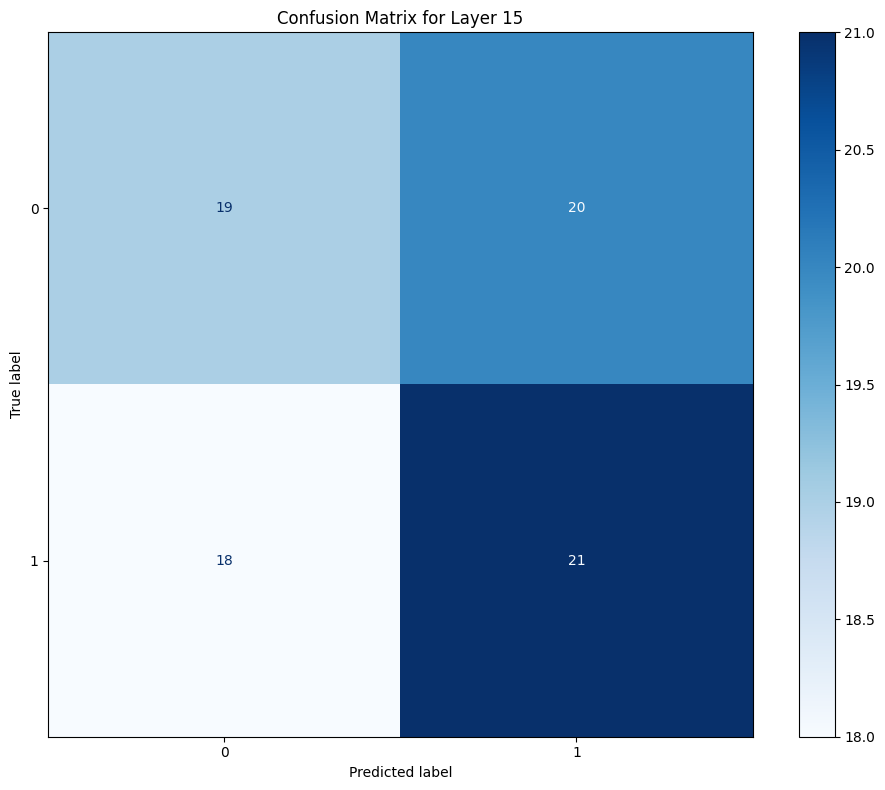

In [50]:
# Plot a confusion matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Choose a specific layer to analyze (e.g., the best performing layer)
best_layer_idx = np.argmax(accuracies)
print(f"Analyzing layer {best_layer_idx} with accuracy: {accuracies[best_layer_idx]:.4f}")

# Get predictions and true labels for the best layer
y_pred = y_preds[best_layer_idx]
y_test = y_tests[best_layer_idx]
print(len(y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=['Reciting', 'Reasoning'])
disp.plot(cmap='Blues', ax=ax)
plt.title(f'Confusion Matrix for Layer {best_layer_idx}')
plt.tight_layout()
plt.show()


### Interpretation

It doesn't seem you can detect whether a model is in the reasoning regime (and outputs the correct answer in the counterfactual case) or wheter it will output the memorization answer (wrong answer in CF case)

However, because the model also scores trivially on the task, this could've been expected. If the model is random guessing, then the activations will also not be very informative.

There is no difference in activations information between reasoning and reciting answers. Perhaps the definition is not entirely valid

###(Q3: Is it possible to detect the reasoning answer (yes/no) even though the model outputs the reciting answer? -> not really possible to do) -- DEPRECATED

In [56]:
# def label_reasoning_answer(example):
#     """Label all instances where the model doesn't output the reasoning answer"""
#     if example['counter_factual_answer'] and example['result'] == 'no':
#         label = 1
#     elif not example['counter_factual_answer'] and example['result'] == 'yes':
#         label = 1
#     else:
#         label = 0
#     return label

# # If mode is just cs, this is just the inverse of correct (if you swap the labels) so should have the same result
# # If mode is real_world, these are all correct instances so should have same result
# # Combination is predict correct instances in real world, predict incorrect instances in counterfactual
# # What meaning does this prediction have?

# data, labels = prepare_data(chess_dataset, 32, label_reasoning_answer, mode='counter_factual')

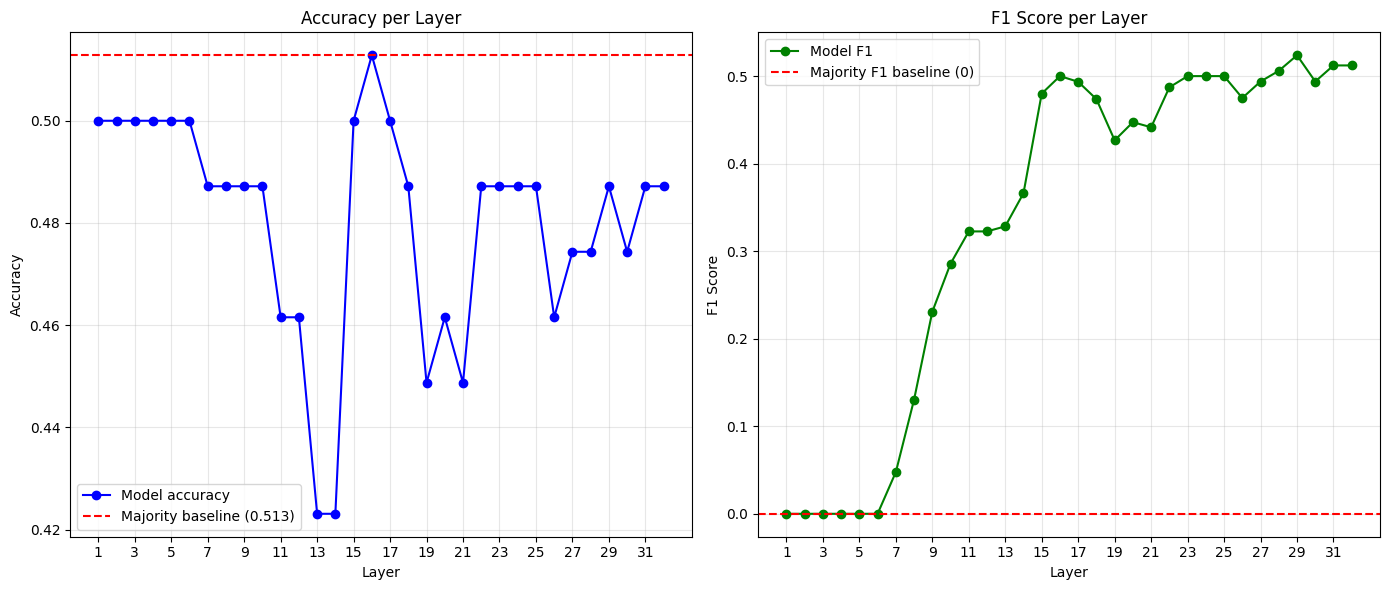

In [58]:
# y_preds, y_tests = train_layer_classifiers(data, labels)
# accuracies, f1_scores = plot_layer_metrics(y_preds, y_tests, labels, num_layers)

### Q4: Can we detect from the model's activations whether we're in the real or counterfactual world?

In [155]:
def label_world(example):
    if example['mode'] == 'real_world':
        label = 1
    else:
        label = 0
    return label

data, labels = prepare_data(chess_dataset, 32, label_world)


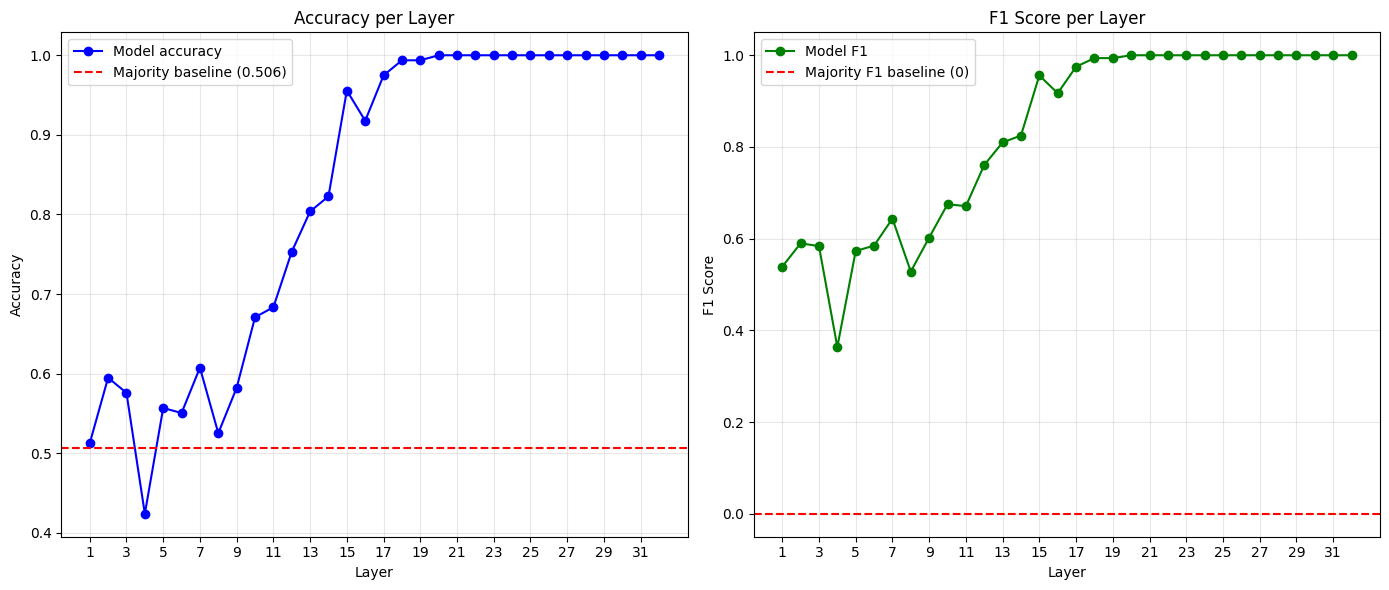

Saved probe coefficients to output/probe_coefficients/world_detection_coefficients.json


In [199]:
# Add noise to a copy of the data
noise_data = [d.copy() for d in data]
for i in range(num_layers):
    X = np.array([d[i] for d in noise_data])
    # Add increasing noise based on layer index
    noise_scale = 0.5 # Scale noise factor
    noise = np.random.normal(0, noise_scale, X.shape)
    X = X + noise
    # Update the noisy data
    for j in range(len(noise_data)):
        noise_data[j][i] = X[j]

# Train with the noisy data
y_preds, y_tests, probes = train_layer_classifiers(noise_data, labels)
# Export the logitic regression probe coefficients
accuracies, f1_scores = plot_layer_metrics(y_preds, y_tests, labels, num_layers)

# Extract and save the logistic regression coefficients
import json
import os

# Create a directory for saving the coefficients if it doesn't exist
os.makedirs("output/probe_coefficients", exist_ok=True)

# Extract coefficients from each layer's probe
coefficients = {}
for layer_idx, probe in enumerate(probes):
    # Get the coefficients (weights) from the logistic regression model
    layer_coefficients = probe.coef_[0].tolist()  # Convert numpy array to list for JSON serialization
    # Also get the intercept
    intercept = probe.intercept_[0].tolist()

    
    coefficients[f"layer_{layer_idx}"] = {
        "weights": layer_coefficients,
        "intercept": intercept
    }

# Save the coefficients to a JSON file
with open("output/probe_coefficients/world_detection_coefficients.json", "w") as f:
    json.dump(coefficients, f, indent=2)

print(f"Saved probe coefficients to output/probe_coefficients/world_detection_coefficients.json")


In [130]:
# Get the first token of the LLM response    
from transformers import AutoTokenizer
import re

# Load the tokenizer for Llama model once
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")

# Print a sample response to understand the format
sample_idx = 0
for i, example in enumerate(chess_dataset):
    if 'llm_response' in example and example['llm_response']:
        sample_idx = i
        break

counter = {
    'counter_factual': {},
    'real_world': {}
}

if 'llm_response' in chess_dataset[sample_idx]:
    print(f"Sample response format: {chess_dataset[sample_idx]['llm_response'][:100]}...")

# Extract the first token of each response
for i, example in enumerate(chess_dataset):

        
    if 'llm_response' in example and example['llm_response']:
        # Split on all occurrences of 'assistant' and get all parts after 'assistant'
        parts = example['llm_response'].split('assistant')
        print(parts)
        first_part = parts[0]
        response = example['llm_response']
        
        # Tokenize just the response
        response_tokens_tmp = tokenizer.encode(first_part)
        final_token_index = len(response_tokens_tmp)
        
        response_tokens = tokenizer.encode(response)
        if response_tokens:
            first_token_id = response_tokens[final_token_index +2]
            first_token = tokenizer.decode([first_token_id])
            if first_token in counter[example['mode']].keys():
                counter[example['mode']][first_token] += 1
            else:
                counter[example['mode']][first_token] = 0

            
            print(f"Example {i}:")
            print(f"Mode: {example['mode']}")
            print(f"First token ID: {first_token_id}")
            print(f"First token: '{first_token}'")
            
            # Show a few tokens from the beginning of the response
            first_few_tokens = tokenizer.convert_ids_to_tokens(response_tokens[final_token_index:final_token_index+5])
            last_few_tokens = tokenizer.convert_ids_to_tokens(response_tokens[final_token_index-5:final_token_index])
            print(f"First few tokens: {first_few_tokens}")
            print(f'last_few_tokens: {last_few_tokens}')
            print("-" * 50)
        




Sample response format: system
You are a chess player. You are playing a chess variant where the starting positions for knig...
['system\nYou are a chess player. You are playing a chess variant where the starting positions for knights and bishops are swapped. For each color, the knights are at placed that where bishops used to be and the bishops are now placed at where knights used to be. Given an opening, determine whether the opening is legal. The opening doesn\'t need to be a good opening. Answer "\\boxed{yes}" if all moves are legal. Answer "\\boxed{no}" if the opening violates any rules of chess.\nuser\n### Question: \nUnder the custom variant, is the new opening "1. g3 Ng6 2. b3 Kf8" legal? \n### Answer: \n', '\nTo determine if the opening "1. g3 Ng6 2. b3 Kf8" is legal under the custom variant, we must check each move individually.\n\n1. g3: This is a legal move in standard chess. The pawn on g2 moves forward one square, which is a valid move. So, this move is legal.\n\n2. Ng6: 

In [131]:
print("Counterfactual")
print(counter['counter_factual'].keys())
for k, v in counter['counter_factual'].items():
    print(f"{k}, count: {v}")

print('Real world')
print(counter['real_world'].keys())

for k, v in counter['real_world'].items():
    print(f"{k}, count: {v}")

Counterfactual
dict_keys(['To', '##', 'The'])
To, count: 193
##, count: 183
The, count: 9
Real world
dict_keys(['\\', 'To', 'The', '##'])
\, count: 333
To, count: 50
The, count: 9
##, count: 2


##### Note
The signal for which world the model is in seems to be very strong as they are still able to predict the world they are in with near perfect accuracy 
- Is there a clear difference in the last token that is predicted between these two worlds (for example always a space in real world and no extra space in counterfactual??) - yes there is
- - \\ occurs exclusively in the real world and often so this is an easy way to distinguish the real world from the counterfactual world, this probably explains the high accuracy on the last layer with added noise as the signal to output \\ is the strongest there

This makes it difficult to conclude that the logistic regression is a belief direction. An ablation study will likely confirm this but is a final check to see what this probe has learned

##### Brainstorm

Possible to perfectly distinguish the real world questions from the reasoning questions. This shouldn't be strange as the prompts are clearly different. However, I would've expected for some of this information to fade as they move through the layers of the network. 

Is it possible to use this 'belief' direction to steer the model to the reasoning answer? To amplify it's belief that it requires reasoning to answer the question? 
- Check if the LiReF paper measures the belief direction of the LLM or if it also looks at the answer 

If this is possible, and performance increases, then the model's belief about the type of question (reasoning or reciting) determines whether it will reason. However, a the big open ended question then still remains on how this reasoning mechanism works.

Does our initial hypothesis, that the model is switching between the answers and that a conflict (when both answers are present) results in the drop of performance, still hold?
- It could hold but we have no evidence both answers are present in the first place.
- We could rerun the chess experiment, only allowing for one output token y/n, and see how y/n propagates through the model's layers?



In [10]:
# # Load the intervention experiment and evaluate ansers:
# import os

# # project_root = "/Users/jorisholshuijsen/Documents/Artificial Intelligence/Thesis/interaction-experiment"
# # intervention_path = os.path.join(project_root, "results/chess/intervention/addition")

# # Load intervention data from the output file
# intervention_file_path = "output/intervention_addition.txt"

# # Initialize a dictionary to store the intervention data
# intervention_data = {"train": []}

# # Read the file and parse the data
# with open(intervention_file_path, "r") as f:
#     content = f.read()
    
#     # Split the content by "Row" to get individual intervention responses
#     rows = content.split("Row ")[1:]  # Skip the first empty element
    
#     for row in rows:
#         if "intervention_response:" in row:
#             # Extract the row number and response
#             row_parts = row.split(" ", 1)
#             if len(row_parts) >= 2:
#                 row_num = int(row_parts[0])
#                 response_data = row_parts[1]
                
#                 # Add to the intervention data
#                 intervention_data["train"].append({
#                     "row": row_num,
#                     "response": response_data
#                 })



In [2]:
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable
distutils: /home/ljilesen/.local/lib/python3.9/site-packages
sysconfig: /home/ljilesen/.local/lib64/python3.9/site-packages
user = True
home = None
root = None
prefix = None


In [3]:
# load the intervention data from huggingface
from datasets import load_from_disk

dataset = load_from_disk("../../../results/chess/intervention/liref/")

print(dataset)



ModuleNotFoundError: No module named 'datasets'

In [11]:
print(len(intervention_data['train']))

800


In [13]:
def evaluate_llm_response(dataset):    
    yes_count = 0
    no_count = 0
    invalid_count = 0
    invalid_answers = []
    
    results = []
    
    for i in range(len(dataset)):
        response = dataset[i]['response']
        
        # Extract the assistant's response part
        if "assistant" in response:
            answer_part = response.split("assistant", 1)[1].strip()
        else:
            print(f"Warning: Could not identify assistant part in response for row {dataset[i]['row']}")
            invalid_count += 1
            invalid_answers.append(response)
            results.append("invalid")
            continue
        
        # Look for boxed yes/no
        has_yes = r"\boxed{yes}" in answer_part
        has_no = r"\boxed{no}" in answer_part
        
        # Check if both yes and no are present
        answer_part = answer_part.replace(".", " ")
        answer_part = answer_part.strip()
        last_line = answer_part.split("\n")[-1]
        success = False
        
        if has_yes and has_no:
            print(f"Warning: Both \\boxed{{yes}} and \\boxed{{no}} found in answer for row {dataset[i]['row']}")
            invalid_answers.append(answer_part)
            invalid_count += 1
            results.append('invalid')
            continue
            
        if has_yes:
            results.append('yes')
            success = True
        elif answer_part.endswith('is legal'):
            results.append("yes")
            success = True
        elif 'are legal' in last_line or 'is legal' in last_line:
            success = True
            results.append("yes")

        if has_no:
            results.append("no")
            success = True
        elif answer_part.endswith('illegal') or answer_part.endswith('not legal'):
            results.append("no")
            success = True
        elif 'not legal' in last_line or 'illegal' in last_line or 'not valid' in last_line or 'not a valid' in last_line:
            results.append("no")
            success = True

        if not success:
            print(f"Warning: Could not identify an answer for row {dataset[i]['row']}")
            invalid_answers.append(answer_part)
            results.append("invalid")

    yes_count = results.count("yes")
    no_count = results.count("no")
    invalid_count = results.count("invalid")
    evaluated_answer_count = len(results)
    if evaluated_answer_count != len(dataset):
        print("Warning: some answers seem to be ambiguous as total evaluated answer length" 
              f"{evaluated_answer_count} does not match the dataset length {len(dataset)}"
              )
    
    print(f"Yes answers: {yes_count}")
    print(f"No answers: {no_count}")
    print(f"Invalid answers: {invalid_count}")
    
    return results, invalid_answers

results, invalid_answers = evaluate_llm_response(intervention_data['train'])

Yes answers: 719
No answers: 45
Invalid answers: 39


In [18]:
# load the jsonl file with the original prompt questions:
import json
# Print the path to help debug file not found errors
import os
print(f"Current working directory: {os.getcwd()}")
print(f"Does the file exist? {os.path.exists('inputs/chess/data/chess_data.jsonl')}")
print(f"Checking parent directories:")
for i in range(4):  # Check up to 3 levels up
    path = os.path.join(*(['..'] * i), 'inputs/chess/data/chess_data.jsonl')
    print(f"  {path}: {os.path.exists(path)}")


# Load the original prompt questions from the jsonl file
chess_data_path = "../../../inputs/chess/data/chess_data.jsonl"
chess_questions = []

with open(chess_data_path, 'r') as f:
    for line in f:
        chess_questions.append(json.loads(line))

print(f"Loaded {len(chess_questions)} chess questions from {chess_data_path}")


Current working directory: /Users/jorisholshuijsen/Documents/Artificial Intelligence/Thesis/interaction-experiment/code/probes/notebooks
Does the file exist? False
Checking parent directories:
  inputs/chess/data/chess_data.jsonl: False
  ../inputs/chess/data/chess_data.jsonl: False
  ../../inputs/chess/data/chess_data.jsonl: False
  ../../../inputs/chess/data/chess_data.jsonl: True
Loaded 800 chess questions from ../../../inputs/chess/data/chess_data.jsonl


In [21]:
rw_correct_yes = 0
rw_correct_no = 0
rw_incorrect = 0
cf_correct_yes = 0
cf_correct_no = 0
cf_incorrect = 0

for i in range(len(chess_questions)):
    if results[i] == 'invalid':
        continue
    if chess_questions[i]['mode'] == 'real_world':
        if results[i] == 'yes' and chess_questions[i]['real_world_answer']:
            rw_correct_yes += 1
        elif results[i] == 'no' and not chess_questions[i]['real_world_answer']:
            rw_correct_no += 1
        else:
            rw_incorrect += 1
    if chess_questions[i]['mode'] == 'counter_factual':
        if results[i] == 'yes' and not chess_questions[i]['counter_factual_answer']:
            cf_correct_yes += 1
        elif results[i] == 'no' and chess_questions[i]['counter_factual_answer']:
            cf_correct_no += 1
        else:
            cf_incorrect += 1

rw_correct = rw_correct_yes + rw_correct_no
cf_correct = cf_correct_yes + cf_correct_no

print(f"Real world correct: {rw_correct_yes} yes, {rw_correct_no} no")
print(f"Real world incorrect: {rw_incorrect}")
print(f"Counter factual correct: {cf_correct_yes} yes, {cf_correct_no} no")
print(f"Counter factual incorrect: {cf_incorrect}")
print(f"Accuracy real world: {rw_correct / (rw_correct + rw_incorrect)}")
print(f"Accuracy counter factual: {cf_correct / (cf_correct + cf_incorrect)}")



Real world correct: 186 yes, 11 no
Real world incorrect: 182
Counter factual correct: 176 yes, 14 no
Counter factual incorrect: 192
Accuracy real world: 0.5197889182058048
Accuracy counter factual: 0.4973821989528796
